## Siemens: Funtional Data Analysis Pipeline (Proposal Version 1.0.0)

**Index**

1. Loading the datasets
2. Preprocessing steps
   - 2.1. Transposing the time series
   - 2.2. Creating new columns
   - 2.3. Merging time series datasets to add additional features
   - 2.3. Removal of unmatched tests
3. Window extraction
   - 3.1. Validating if there are partial or full missing values after the extraction
   - 3.2. Validating shape post-window extraction
   - 3.4. Scaling the post-window data: Zero Start
   - 3.4. Windows visualization
3. Balancing the specific attributes
5. FPCA characterization
   - 5.1. Functional PC1 plots (both systems)  Characterization of FPC Scores
6. Bootstrapping CI
7. Functional 

In [1]:
#!pip install scikit-fda

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
import statsmodels.api as sm
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.exploratory.visualization import FPCAPlot
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot
# Import designed-functions
from window_calculator import calculate_window_values
from window_extractor import calculate_window_data
from time_series_visualization import plot_all_time_series, plot_all_time_series_and_mean_fpca
from time_series_grouped_visualization import plot_all_time_series_in_group
from windows_merge import Merge_data
from scaling import align_to_zero
from functional_pca import fpca_two_inputs
from first_component_bootstrap import bootstrap
from scores_visualization import create_pc_scores_plots
from fpc1_extraction import first_component_extraction
from slr_visualization import visualize_regression
from functional_regression import Function_regression, coefficent_visualization

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11176\2748040198.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 1. Loading the datasets

The path of the files can be change based on where the data is stored.

In [3]:
# Import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 2. Preprocesing Steps

## 2.1. Transposing the time series

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

## 2.2. Creating new columns

In [6]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.
keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})

## 2.3. Merging time series datasets to add additional features

In [7]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


## 2.3. Removal of unmatched tests

In [8]:
# Remove the testID only exists in one sensor
# Note: Only run once. If not, restart the kernel and run from the beggining again.
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3377)
A2:  (7743, 3368)
B1:  (3374, 3377)
B2:  (7743, 3368)


# 3. Window extraction

In [9]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor B

# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))


In [10]:
# Adds TestIDs as index to the values post-window extraction 
# System 1 - Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B

B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID'].astype(int)
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B

B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID'].astype(int)
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)

## 3.1. Validating if there are partial or full missing values after the extraction

In [11]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

B1_cal_window_drop_index = B1_cal_window.loc[B1_cal_window.isna().sum(axis=1)!=0].index
B2_cal_window_drop_index = B2_cal_window.loc[B2_cal_window.isna().sum(axis=1)!=0].index

B1_sample_window_drop_index = B1_sample_window.loc[B1_sample_window.isna().sum(axis=1)!=0].index
B2_sample_window_drop_index = B2_sample_window.loc[B2_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_cal_window_drop_index)
print("The missing value in sample window:",B1_sample_window_drop_index)
print("The missing value in calibration window:",B2_cal_window_drop_index)
print("The missing value in sample window:",B2_sample_window_drop_index)

The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')


## 3.2. Validating data shape post-window extraction

In [12]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_cal_window: ', A1_cal_window.shape)
print('A2_cal_window: ', A2_cal_window.shape)
print('B1_cal_window: ', B1_cal_window.shape)
print('B2_cal_window: ', B2_cal_window.shape)

# Sample Window
print('A1_sample_window: ', A1_sample_window.shape)
print('A2_sample_window: ', A2_sample_window.shape)
print('B1_sample_window: ', B1_sample_window.shape)
print('B2_sample_window: ', B2_sample_window.shape)

Shape of the time series after extraction
A1_cal_window:  (3374, 41)
A2_cal_window:  (7743, 41)
B1_cal_window:  (3374, 91)
B2_cal_window:  (7743, 91)
A1_sample_window:  (3374, 26)
A2_sample_window:  (7743, 26)
B1_sample_window:  (3374, 21)
B2_sample_window:  (7743, 21)


## 3.3. Scaling the post-window data: zero-alignment

In [13]:
# Cal Window

A1_cal_window_zero = align_to_zero(A1_cal_window)
A2_cal_window_zero = align_to_zero(A2_cal_window)
B1_cal_window_zero = align_to_zero(B1_cal_window)
B2_cal_window_zero = align_to_zero(B2_cal_window)


# Sample Window

A1_sample_window_zero = align_to_zero(A1_sample_window)
A2_sample_window_zero = align_to_zero(A2_sample_window)
B1_sample_window_zero = align_to_zero(B1_sample_window)
B2_sample_window_zero = align_to_zero(B2_sample_window)


## 3.4. Combination of the time series and features in the same table

We have the xx_xx_window (e.g. B2_blood_cal_window) variable which contains the time series value and also xx_Merged (e.g. A1_Merged) which includes the features [Card_Age, Fluid temperature, Fluid_Type and Ambient temperature].

 In the following part, we try to combine them for the windows visualization (5) and functional regression (7).

In [14]:
# Set index for Merge datasets
A1_Merged.set_index("TestID", inplace=True)
A2_Merged.set_index("TestID", inplace=True)
B1_Merged.set_index("TestID", inplace=True)
B2_Merged.set_index("TestID", inplace=True)

# Combine data
A1_cal_window_combine = Merge_data(A1_cal_window_zero,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window_zero,A2_Merged)

B1_cal_window_combine = Merge_data(B1_cal_window_zero,B1_Merged)
B2_cal_window_combine = Merge_data(B2_cal_window_zero,B2_Merged)

A1_cal_window_combine = Merge_data(A1_cal_window_zero,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window_zero,A2_Merged)

B1_cal_window_combine = Merge_data(B1_cal_window_zero,B1_Merged)
B2_cal_window_combine = Merge_data(B2_cal_window_zero,B2_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window_zero,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window_zero,A2_Merged)

B1_sample_window_combine = Merge_data(B1_sample_window_zero,B1_Merged)
B2_sample_window_combine = Merge_data(B2_sample_window_zero,B2_Merged)

# 4. Balancing the specific attributes

In [15]:
def balance_by_temperature(data, temperature_column='Fluid_Temperature_Filled', bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'], total_size=None, random_state=24):
    """
    Balances the dataset based on the fluid temperature bins, taking the total data size into account.

    Parameters:
    data (pd.DataFrame): The input dataset.
    temperature_column (str): The column name for fluid temperature.
    bins (list): The bin edges for discretizing temperature.
    labels (list): The labels for the bins.
    total_size (int): The desired total size of the balanced dataset. If None, the function will balance the data based on the minimum bin size.
    random_state (int): The seed for the random number generator to ensure reproducibility.

    Returns:
    pd.DataFrame: The balanced dataset.
    pd.Series: The index from the balanced dataset
    """
    # Discretize the temperature values into bins and assign labels
    data['FluidTempBin'] = pd.cut(data[temperature_column], bins=bins, labels=labels)
    
    # Sample the data from each bin
    balanced_data = data.groupby('FluidTempBin').apply(lambda x: x.sample(n=72, random_state=random_state))
    balanced_data_index = balanced_data.index
    balanced_data = balanced_data.reset_index(drop=True)
    return balanced_data, balanced_data_index.get_level_values(1)

A1_Merged_balanced,A1_Merged_balanced_index = balance_by_temperature(A1_Merged)
A2_Merged_balanced,A2_Merged_balanced_index = balance_by_temperature(A2_Merged)
B1_Merged_balanced,B1_Merged_balanced_index = balance_by_temperature(B1_Merged)
B2_Merged_balanced,B2_Merged_balanced_index = balance_by_temperature(B2_Merged)

print("A1_Merged_balanced shape:", A1_Merged_balanced.shape)
print("A2_Merged_balanced shape:", A2_Merged_balanced.shape)
print("B1_Merged_balanced shape:", B1_Merged_balanced.shape)
print("B2_Merged_balanced shape:", B2_Merged_balanced.shape)


A1_Merged_balanced shape: (216, 3381)
A2_Merged_balanced shape: (216, 3372)
B1_Merged_balanced shape: (216, 3381)
B2_Merged_balanced shape: (216, 3372)


In [16]:
def inspect_bins(data, temperature_column='Fluid_Temperature_Filled', bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26']):
    """
    Inspects the distribution of samples across temperature bins.

    Parameters:
    data (pd.DataFrame): The input dataset.
    temperature_column (str): The column name for fluid temperature.
    bins (list): The bin edges for discretizing temperature.
    labels (list): The labels for the bins.

    Returns:
    pd.Series: The count of samples in each temperature bin.
    """
    data['FluidTempBin'] = pd.cut(data[temperature_column], bins=bins, labels=labels)
    return data['FluidTempBin'].value_counts()

# Bins length inspection_balanced
print("A1_Merged distribution:\n", inspect_bins(A1_Merged_balanced))
print("A2_Merged distribution:\n", inspect_bins(A2_Merged_balanced))
print("B1_Merged distribution:\n", inspect_bins(B1_Merged_balanced))
print("B2_Merged distribution:\n", inspect_bins(B2_Merged_balanced))


A1_Merged distribution:
 Below 20    72
20-26       72
Above 26    72
Name: FluidTempBin, dtype: int64
A2_Merged distribution:
 Below 20    72
20-26       72
Above 26    72
Name: FluidTempBin, dtype: int64
B1_Merged distribution:
 Below 20    72
20-26       72
Above 26    72
Name: FluidTempBin, dtype: int64
B2_Merged distribution:
 Below 20    72
20-26       72
Above 26    72
Name: FluidTempBin, dtype: int64


# 5. Windows visualization


### 5.1. Fluid Temperature

#### System 1 and System 2: Sensor A - Cal and Sample Windows

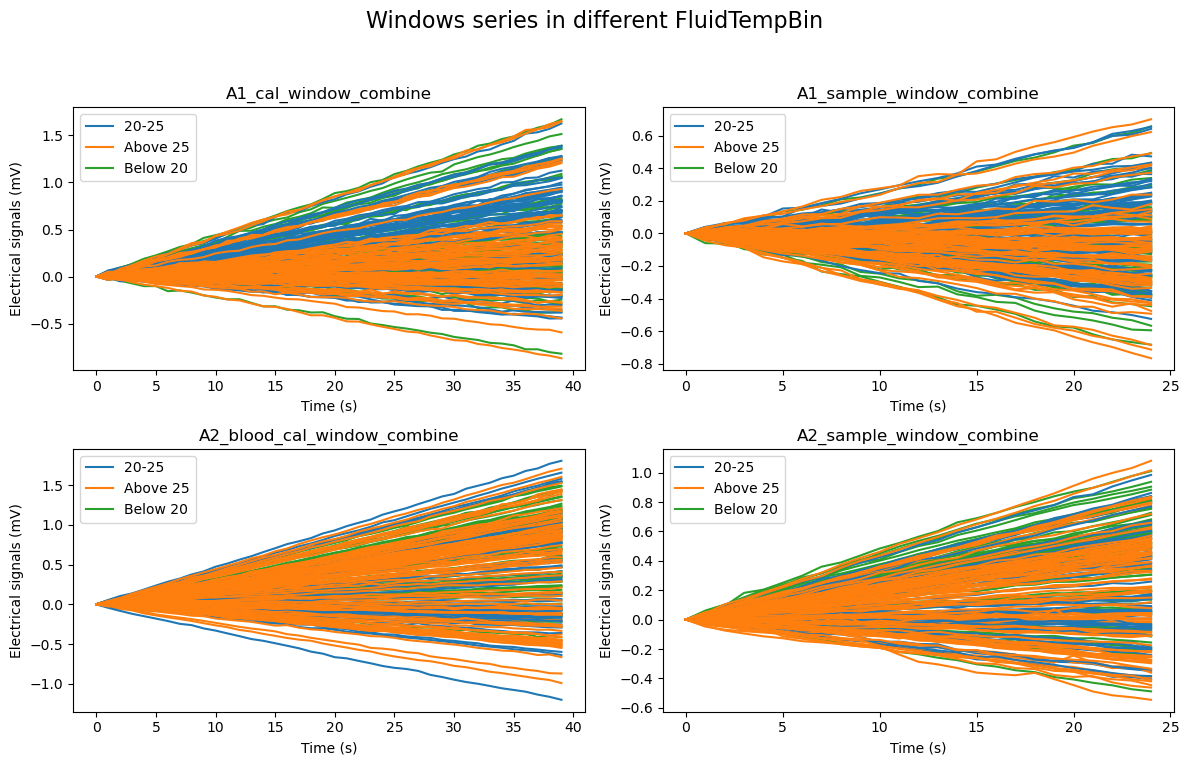

In [17]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(A1_cal_window_combine.loc[A1_Merged_balanced_index], A1_sample_window_combine.loc[A1_Merged_balanced_index], A2_cal_window_combine.loc[A2_Merged_balanced_index], A2_sample_window_combine.loc[A2_Merged_balanced_index],"FluidTempBin", "A1_cal_window_combine", "A1_sample_window_combine","A2_blood_cal_window_combine", "A2_sample_window_combine")

#### System 1 and System 2: Sensor B - Cal and Sample Windows

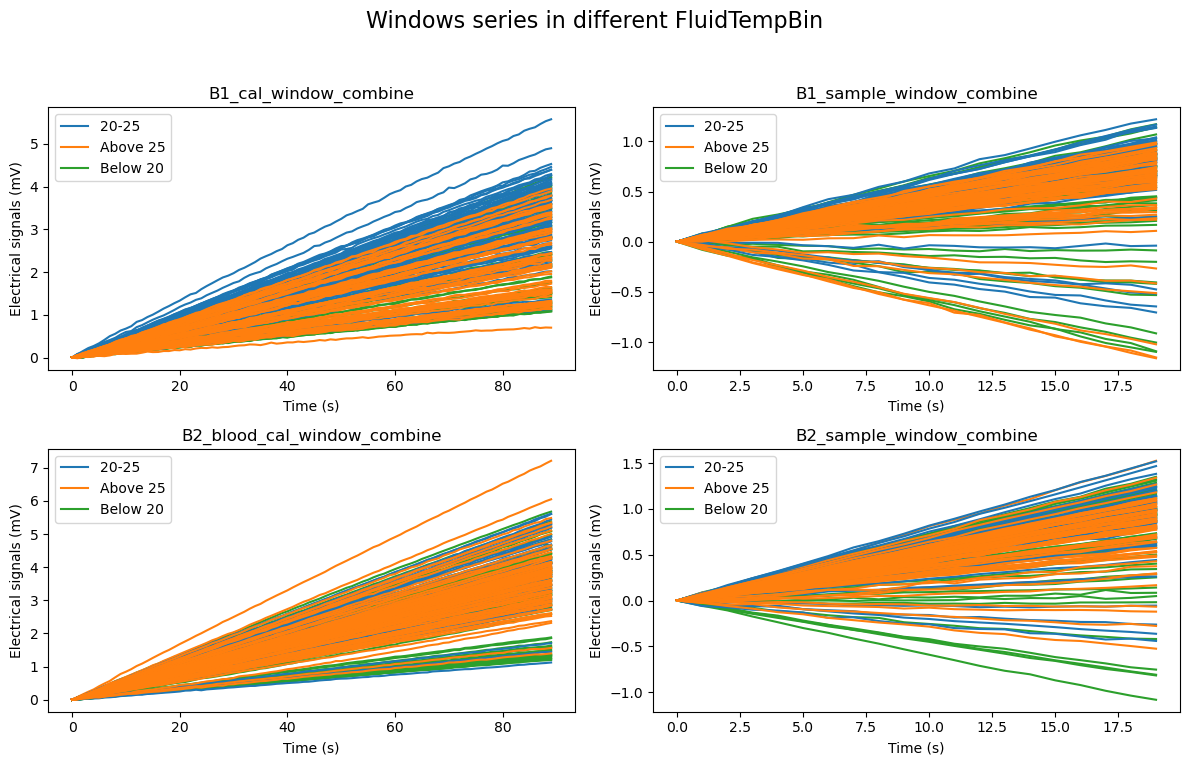

In [18]:
# Plot all the time series from the window extraction
plot_all_time_series_in_group(B1_cal_window_combine.loc[B1_Merged_balanced_index], B1_sample_window_combine.loc[B1_Merged_balanced_index], B2_cal_window_combine.loc[B2_Merged_balanced_index], B2_sample_window_combine.loc[B2_Merged_balanced_index], "FluidTempBin", "B1_cal_window_combine", "B1_sample_window_combine", "B2_blood_cal_window_combine", "B2_sample_window_combine")


# 5. FPCA characterization

## 5.1. Functional PC1 plots (both systems) and Characterization of FPC Scores

The following secssion will introduce 
1. Explan variance
2. Waveforms with significant features of different components
3. Plot 1-2: all the waveforms and one mean waveform after aggregating
4. Plot 3-4: The first two component in different systems
5. Plot 5: The first component of two systems in the same canvas
6. Plot 6: The confidential interval of two systems by bootstrap
7. Plot 7-8: The boxplots in two systems show the different percentile about the first component
    - Red dashed lines indicate detected outliers
    - Red area shows the box region
8. Plot 9-12: The visualization of PCA component scores

### System 1 versus System 2: Sensor A - Cal Window

S1 Explain variance PC1 (%):  99.8665916983416
S1 Explain variance PC2 (%):  0.03630721184902695
S2 Explain variance PC1 (%):  99.95667137215179
S2 Explain variance PC2 (%):  0.014207672624760137
The time series contributing most to PC1 is at index 38 with TestID 12191139.0
The time series contributing most to PC2 is at index 81 with TestID 12480607.0
The time series contributing most to PC1 is at index 116 with TestID 3568375
The time series contributing most to PC2 is at index 141 with TestID 3572414


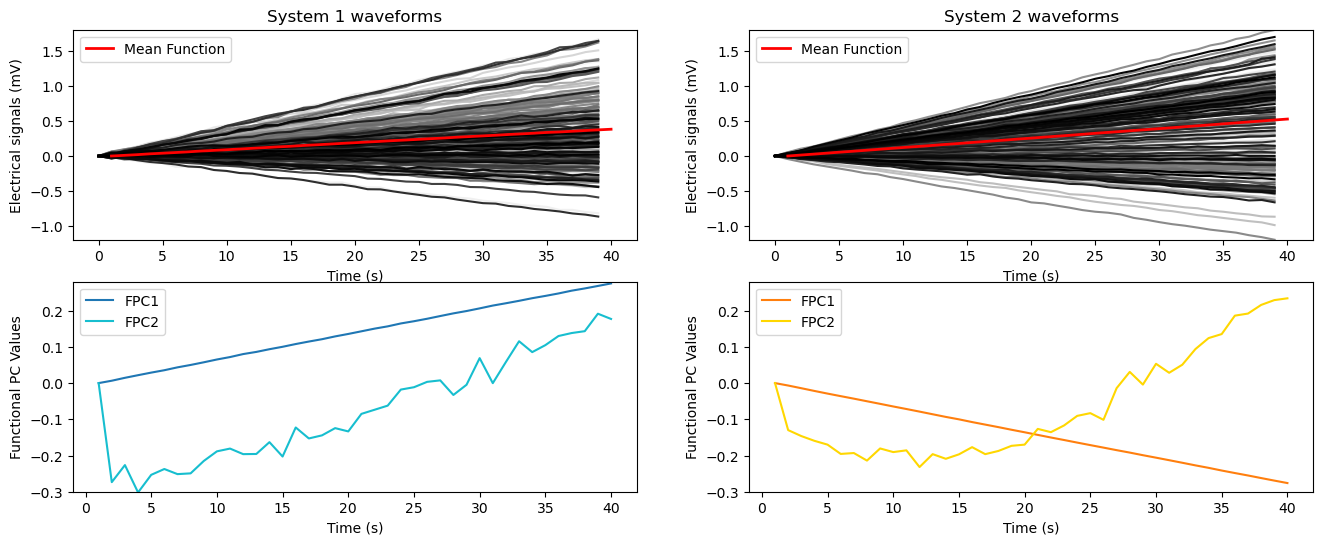

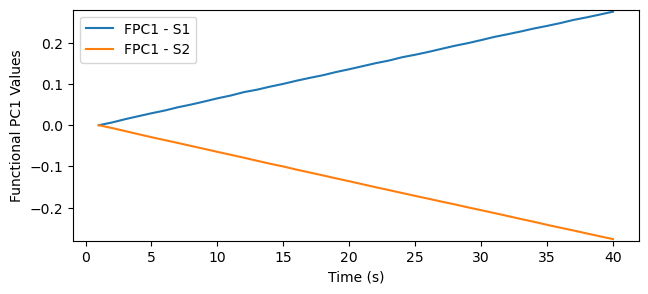

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


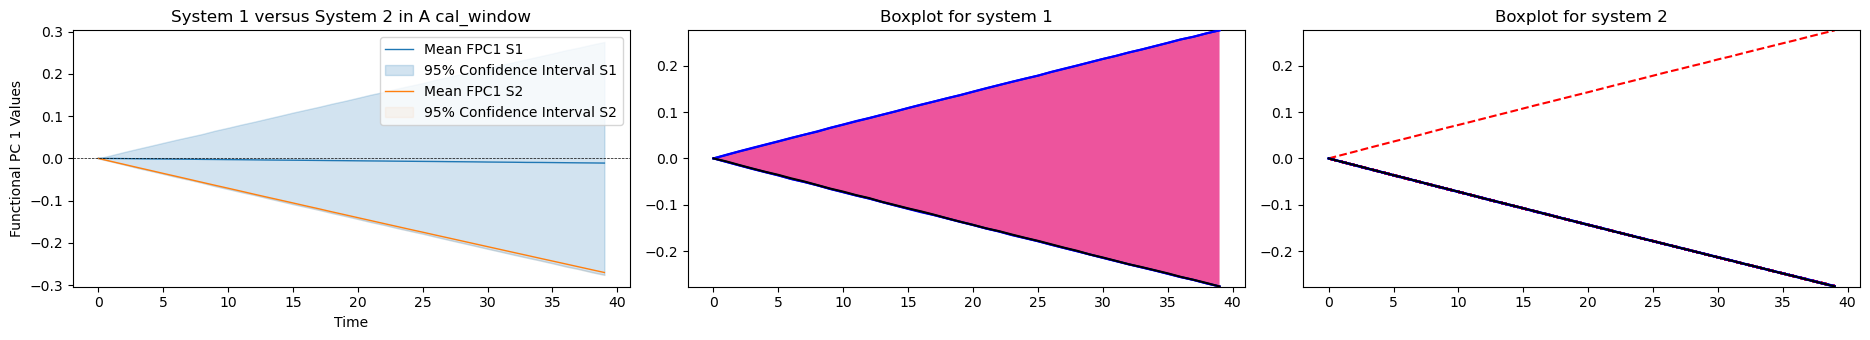

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [19]:
pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window,fpca_s1_A_cal_window,fpca_s2_A_cal_window = fpca_two_inputs(A1_cal_window_zero.loc[A1_Merged_balanced_index], A2_cal_window_zero.loc[A2_Merged_balanced_index], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
ac1, ac2 = bootstrap(A1_cal_window_combine,A2_cal_window_combine ,"A","cal_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window, A1_Merged, A2_Merged)

### System 1 versus System 2: Sensor A - Sample Window

S1 Explain variance PC1 (%):  99.49539895933508
S1 Explain variance PC2 (%):  0.17796002065847868
S2 Explain variance PC1 (%):  99.82553391005435
S2 Explain variance PC2 (%):  0.08974847762093409
The time series contributing most to PC1 is at index 170 with TestID 12190942.0
The time series contributing most to PC2 is at index 70 with TestID 12191109.0
The time series contributing most to PC1 is at index 78 with TestID 3568670
The time series contributing most to PC2 is at index 200 with TestID 3553760


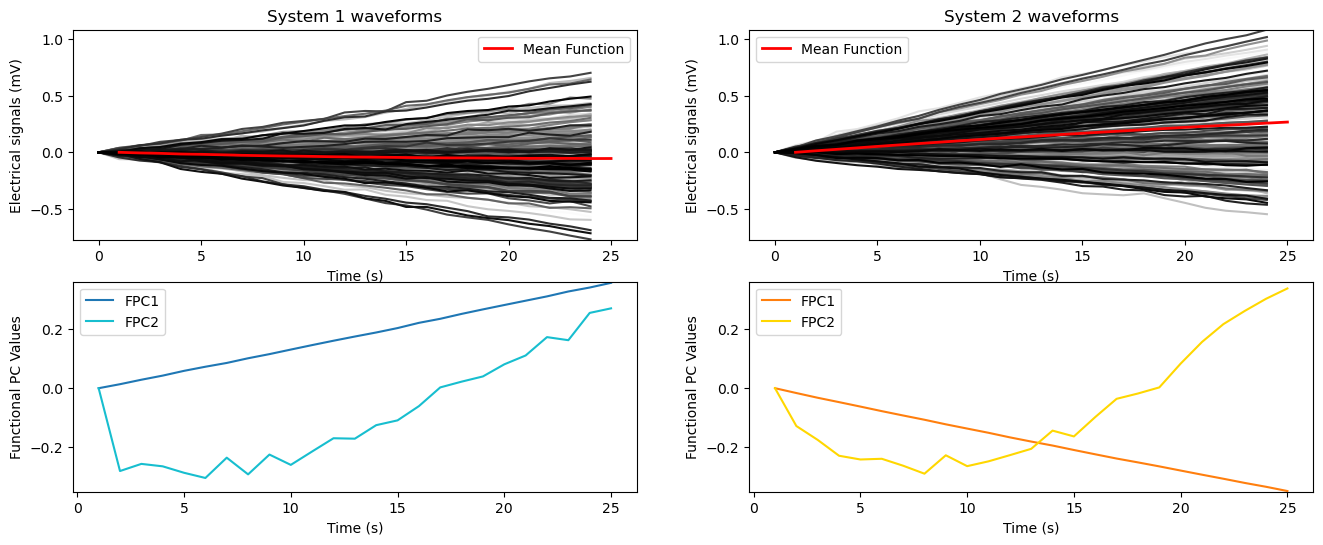

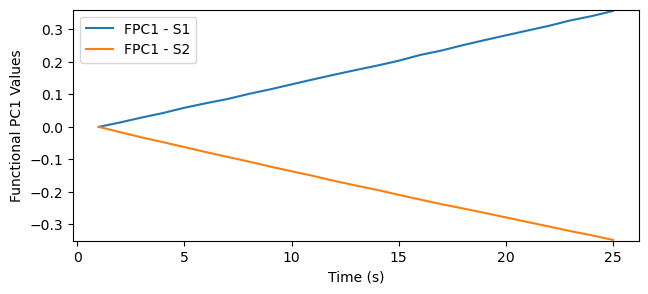

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


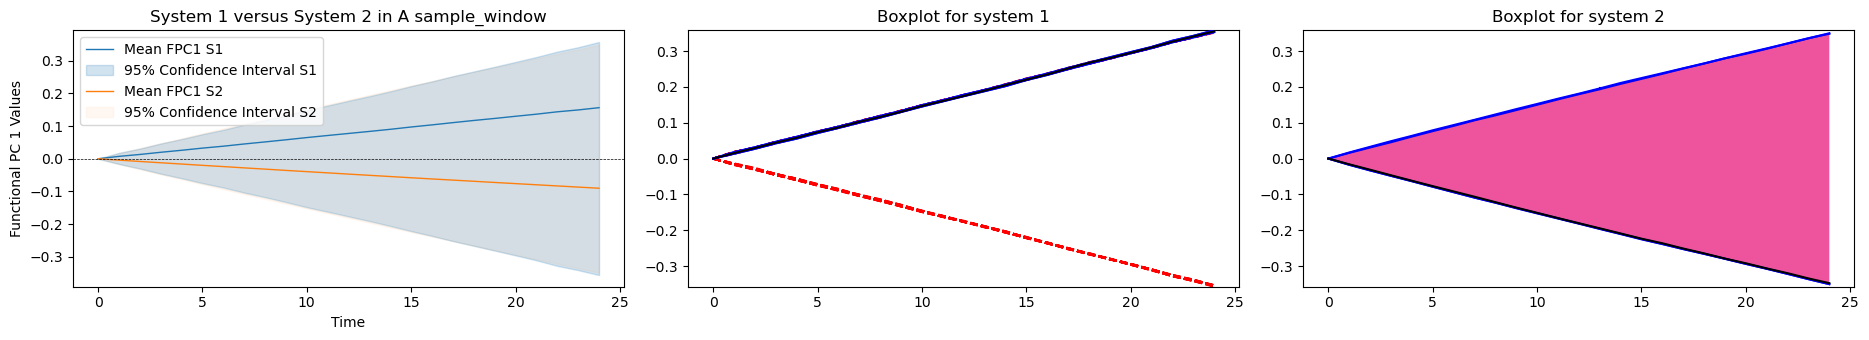

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [20]:
pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window,fpca_s1_A_sample_window,fpca_s2_A_sample_window = fpca_two_inputs(A1_sample_window_zero.loc[A1_Merged_balanced_index], A2_sample_window_zero.loc[A2_Merged_balanced_index], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
as1,as2 = bootstrap(A1_sample_window_combine,A2_sample_window_combine ,"A","sample_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window, A1_Merged, A2_Merged)

### System 1 versus System 2: Sensor B - Cal Window

S1 Explain variance PC1 (%):  99.91884931001336
S1 Explain variance PC2 (%):  0.04568447135784855
S2 Explain variance PC1 (%):  99.91872001665526
S2 Explain variance PC2 (%):  0.06608532384757787
The time series contributing most to PC1 is at index 123 with TestID 12397155.0
The time series contributing most to PC2 is at index 61 with TestID 12514378.0
The time series contributing most to PC1 is at index 90 with TestID 3568922.0
The time series contributing most to PC2 is at index 165 with TestID 3559332.0


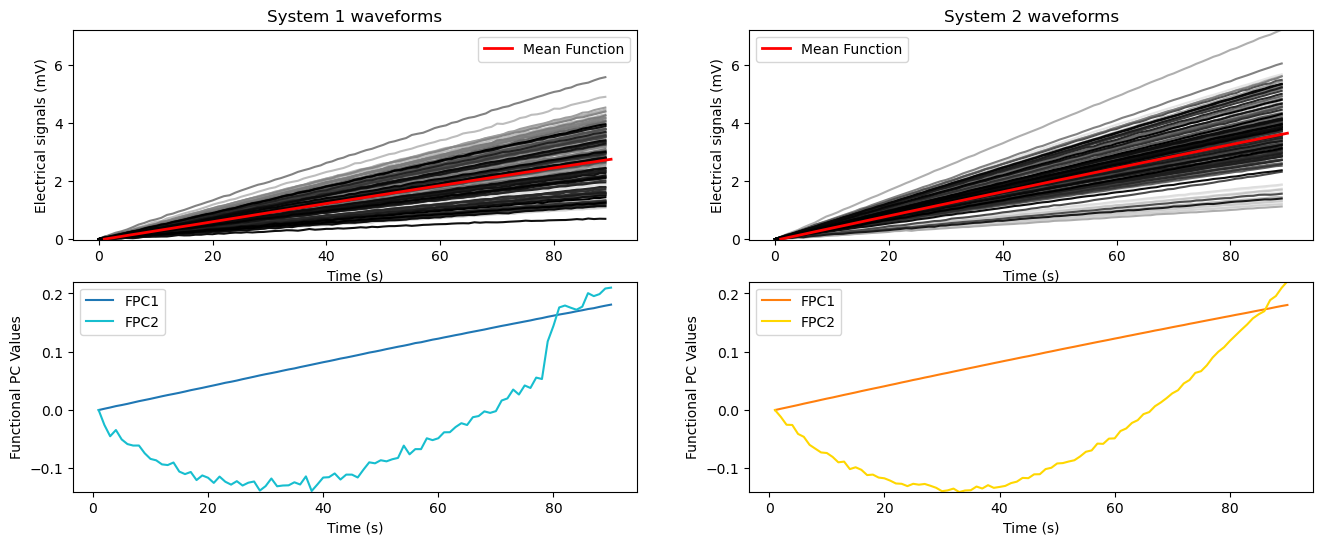

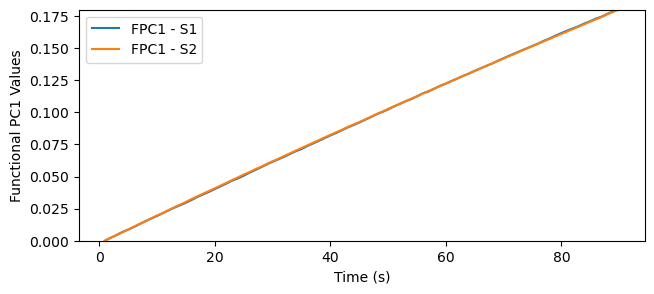

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


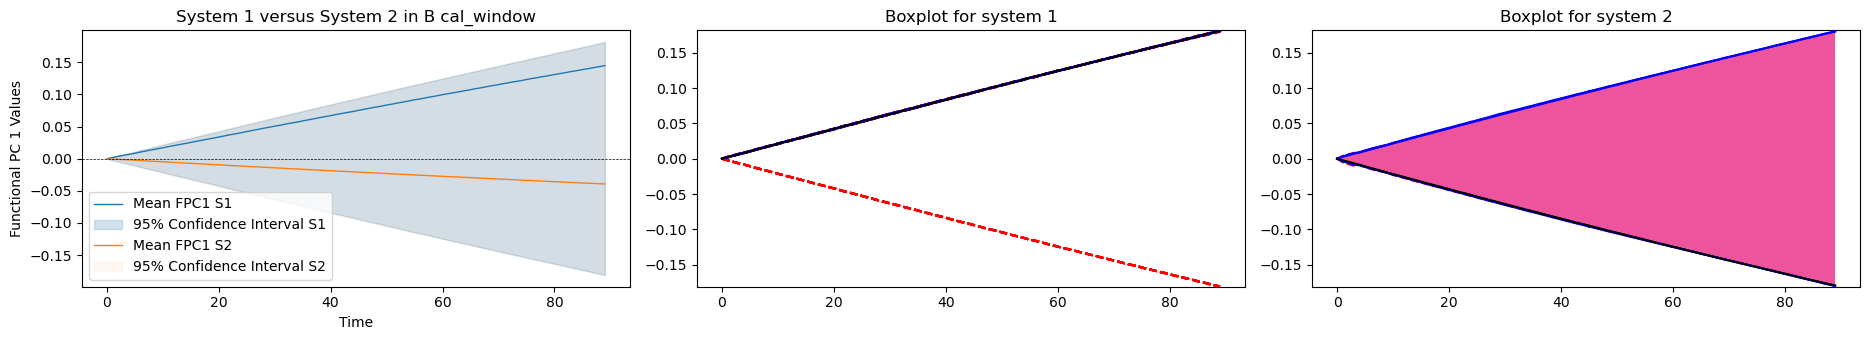

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [21]:
pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window,fpca_s1_B_cal_window,fpca_s2_B_cal_window = fpca_two_inputs(B1_cal_window_zero.loc[B1_Merged_balanced_index], B2_cal_window_zero.loc[B2_Merged_balanced_index], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bc1,bc2 = bootstrap(B1_cal_window_combine,B2_cal_window_combine ,"B","cal_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window, B1_Merged, B2_Merged)

### System 1 versus System 2: Sensor B - Sample Window

S1 Explain variance PC1 (%):  99.85051864838915
S1 Explain variance PC2 (%):  0.03693256228246013
S2 Explain variance PC1 (%):  99.89500923311329
S2 Explain variance PC2 (%):  0.049637875016325834
The time series contributing most to PC1 is at index 203 with TestID 12191206.0
The time series contributing most to PC2 is at index 51 with TestID 12192124.0
The time series contributing most to PC1 is at index 5 with TestID 3518443.0
The time series contributing most to PC2 is at index 134 with TestID 3564497.0


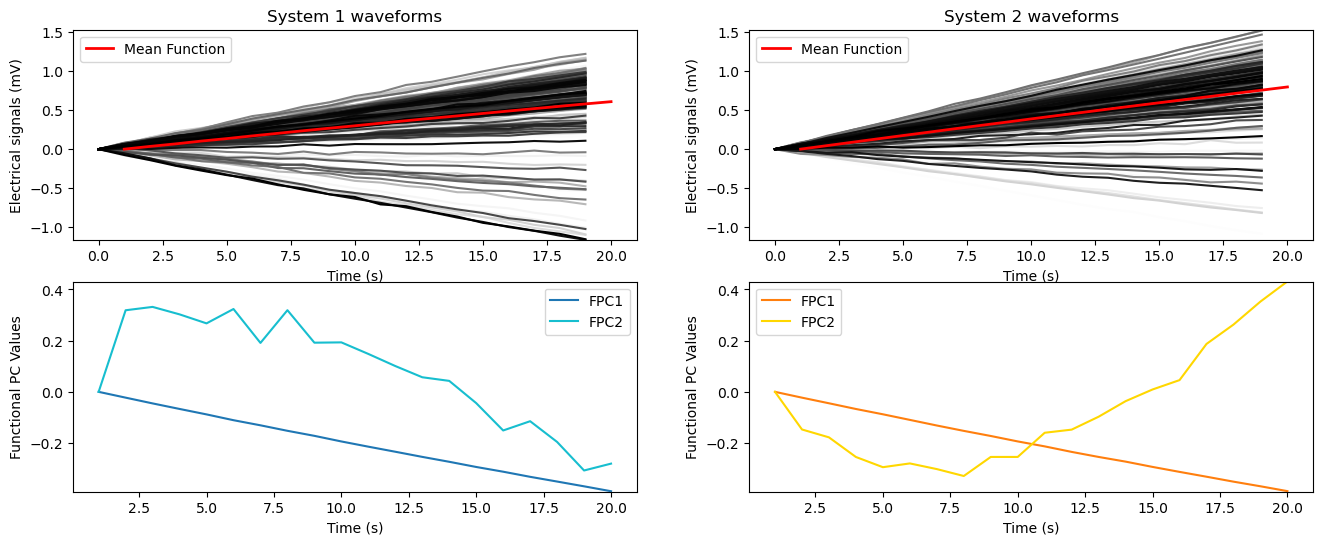

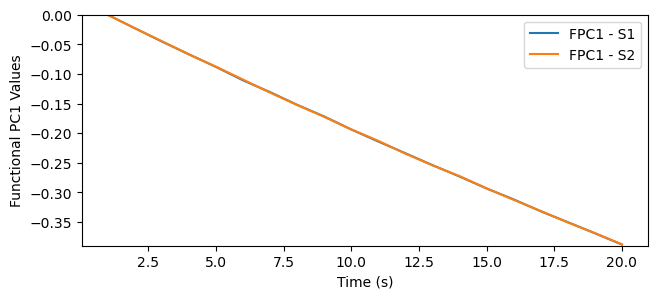

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


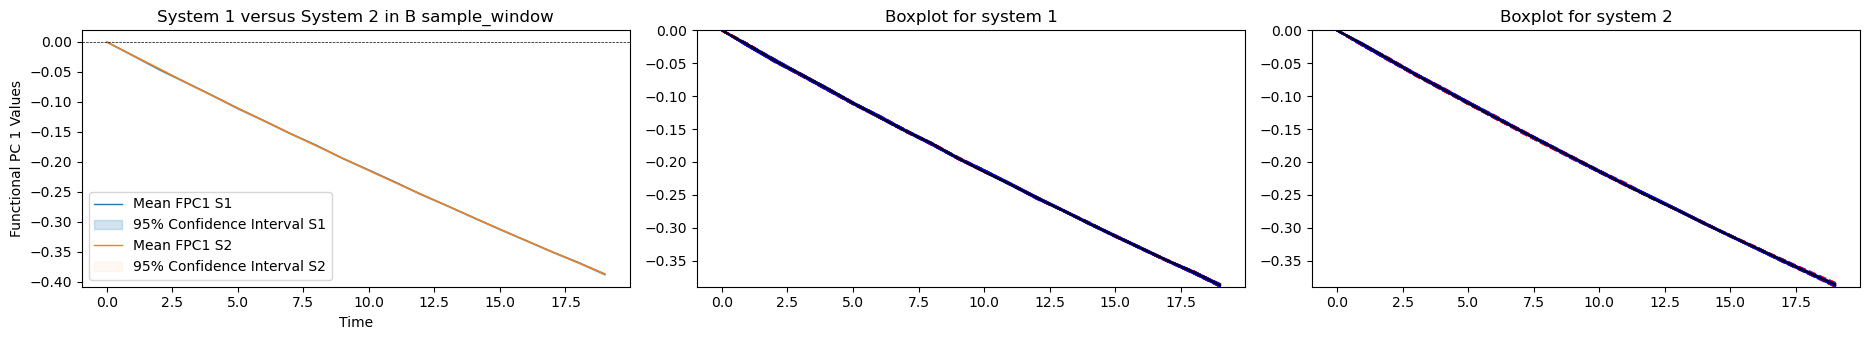

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [22]:
pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window,fpca_s1_B_sample_window,fpca_s2_B_sample_window = fpca_two_inputs(B1_sample_window_zero.loc[B1_Merged_balanced_index], B2_sample_window_zero.loc[B2_Merged_balanced_index], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bs1,bs2 = bootstrap(B1_sample_window_combine,B2_sample_window_combine ,"B","sample_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window, B1_Merged, B2_Merged)

## 5.2 Linear Regression for slope

### R-square and visualization

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.958e+05
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           8.21e-80
Time:                        11:52:02   Log-Likelihood:                 233.02
No. Observations:                  40   AIC:                            -462.0
Df Residuals:                      38   BIC:                            -458.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      0.000    -25.235      0.0

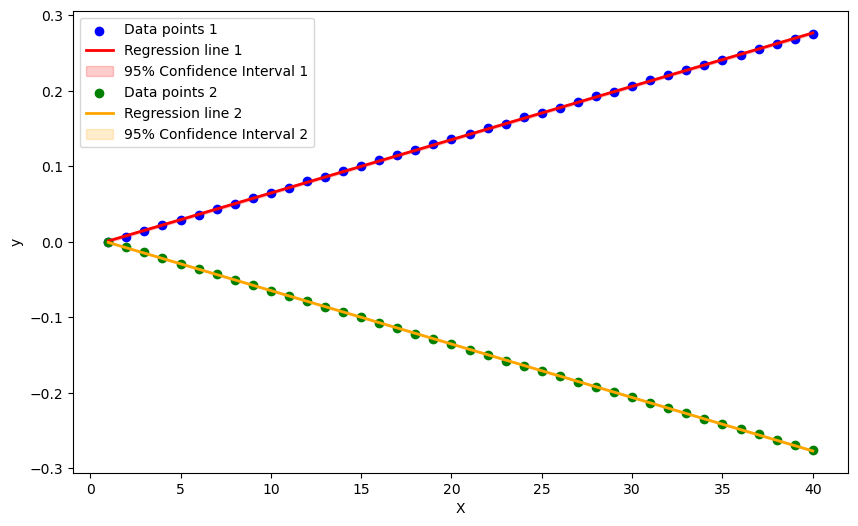

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.489e+05
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           2.44e-45
Time:                        11:52:02   Log-Likelihood:                 130.01
No. Observations:                  25   AIC:                            -256.0
Df Residuals:                      23   BIC:                            -253.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0173      0.001    -30.141      0.0

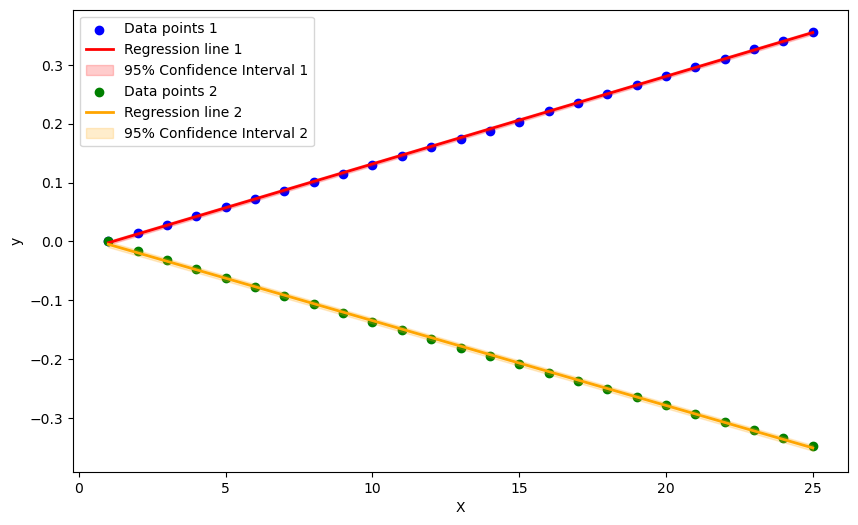

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.200e+05
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          1.80e-158
Time:                        11:52:03   Log-Likelihood:                 505.95
No. Observations:                  90   AIC:                            -1008.
Df Residuals:                      88   BIC:                            -1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.365      0.1

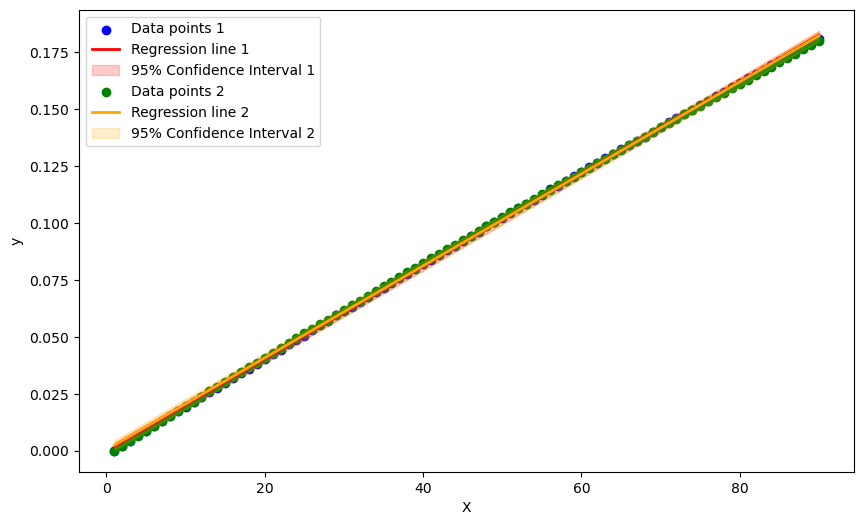

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.484e+04
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           1.02e-29
Time:                        11:52:03   Log-Likelihood:                 86.746
No. Observations:                  20   AIC:                            -169.5
Df Residuals:                      18   BIC:                            -167.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0139      0.002      8.973      0.0

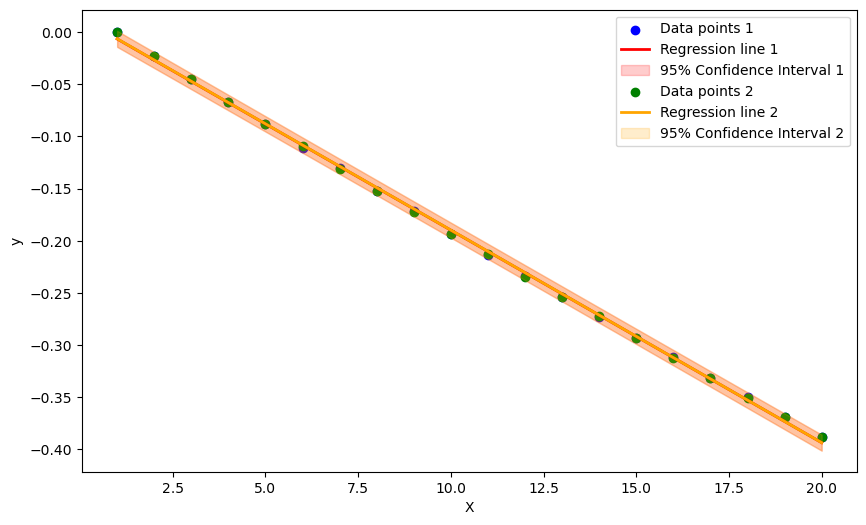

In [23]:
df_list = []

def append_to_dataframe(window_name, slope1, slope2):
    global df_list
    df_list.append({'Window': window_name, 'Slope 1': slope1, 'Slope 2': slope2})
append_to_dataframe('A_cal_window', *visualize_regression(fpca_s1_A_cal_window, fpca_s2_A_cal_window))
append_to_dataframe('A_sample_window', *visualize_regression(fpca_s1_A_sample_window, fpca_s2_A_sample_window))
append_to_dataframe('B_cal_window', *visualize_regression(fpca_s1_B_cal_window, fpca_s2_B_cal_window))
append_to_dataframe('B_sample_window', *visualize_regression(fpca_s1_B_sample_window, fpca_s2_B_sample_window))

### Slopes Results Comparison for one sample

In [24]:
slopes_df = pd.DataFrame(df_list)
slopes_df

Window   Slope 1   Slope 2
0     A_cal_window  0.007067 -0.007082
1  A_sample_window  0.014885 -0.014414
2     B_cal_window  0.002032  0.002022
3  B_sample_window -0.020376 -0.020380

# 6. Functional Regression

This is another functional analysis method. Unlike FPCA, the following analysis utilizes **the entire time series** in a balanced and centered dataset as  response variables for regression with **the features before grouping by bins**. This is done to distinguish between two systems under the influence of features.

## 6.1 Regression coefficient

This is the coeffcient from the output of the model.
Because of the different magnitude, we need to choose the time stamps before we visualize

### Sensor A

#### Cal window

In [25]:
print("System 1:")
A1_cal_window_funct_reg = Function_regression(A1_cal_window_combine.loc[A1_Merged_balanced_index],40,["Fluid_Temperature_Filled"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_cal_window_funct_reg = Function_regression(A2_cal_window_combine.loc[A2_Merged_balanced_index],40,["Fluid_Temperature_Filled"])

System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 39.0),), n_basis=41, period=39.0),
    coefficients=[[ 2.42129304e+00 -8.62444926e-01 -1.44250360e-01 -3.86426253e-01
      -4.67396583e-02 -2.55585385e-01  2.09115142e-01 -1.03255075e-01
       1.49107595e-01 -2.18056227e-01 -6.77483804e-02 -2.19960508e-01
       1.70427650e-02 -1.42510878e-01  6.26976049e-03 -3.27701867e-01
       5.65702263e-02 -1.13893336e-01 -4.63953901e-03 -1.27766159e-01
       2.09838723e-02 -9.16932745e-02 -4.04053710e-02 -4.89569954e-01
      -1.72634844e-01 -2.85242392e-01 -1.78307325e-01 -8.21793440e-02
       1.78313302e-01 -3.93034060e-01  1.25017884e-01 -4.07086854e-01
       2.45051987e-01 -7.18928598e-01 -1.08453903e-01 -6.44016399e-01
      -2.15173155e-01 -1.06274608e+14  6.92999741e+11 -1.06274608e+14
      -6.92999741e+11]]) 

Coefficient of Fluid_Temperature_Filled: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 39.0),), n_basis=41, period=39.0),

#### Sample window

In [26]:
print("System 1:")
A1_sample_window_funct_reg = Function_regression(A1_sample_window_combine.loc[A1_Merged_balanced_index],25,["Fluid_Temperature_Filled"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_sample_window_funct_reg = Function_regression(A2_sample_window_combine.loc[A2_Merged_balanced_index],25,["Fluid_Temperature_Filled"])


System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 24.0),), n_basis=25, period=24.0),
    coefficients=[[ 8.75286239e-02 -1.62233973e-01  5.30152834e-04 -1.18383763e-01
      -1.13095787e-01  2.91575960e-02 -7.07026475e-02  7.51447141e-02
       6.04781728e-03  8.55943610e-02 -1.25418013e-02  2.34464760e-03
       1.66217244e-02  2.33341197e-02 -9.80066346e-02 -1.33251085e-01
      -1.16043513e-02 -8.67357752e-02 -3.41755045e-03 -1.78016233e-02
       5.26318994e-02 -7.06075051e-02  2.84851135e-04 -2.78202646e+13
      -5.02007846e-02]]) 

Coefficient of Fluid_Temperature_Filled: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 24.0),), n_basis=25, period=24.0),
    coefficients=[[-1.10106934e-02  8.20383132e-03  2.22583489e-03  5.82930327e-03
       5.13989499e-03 -2.54274364e-03  2.37653309e-03 -3.30040258e-03
      -1.36207292e-03 -4.16808744e-03 -3.62199476e-03  6.25908794e-03
      -2.34895135e-03 -3.16180249e-04  5.59310071e-03  8

### Sensor B

#### Cal window

In [27]:
print("System 1:")
B1_cal_window_funct_reg = Function_regression(B1_cal_window_combine.loc[B1_Merged_balanced_index],90,["Fluid_Temperature_Filled"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_cal_window_funct_reg = Function_regression(B2_cal_window_combine.loc[B2_Merged_balanced_index],90,["Fluid_Temperature_Filled"])



System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 89.0),), n_basis=91, period=89.0),
    coefficients=[[ 1.34761239e+01 -5.74948597e+00 -1.25038374e+00 -2.07114677e+00
       6.91822600e-02 -2.69665648e+00  2.93271693e-01 -1.23948734e+00
      -4.29589449e-01 -4.25890704e-01 -1.40108192e+00 -7.14567774e-01
       9.31790993e-01  1.43724813e-01  8.25978892e-01 -1.36880176e+00
       1.34589050e+00 -4.51335895e-02  8.40503732e-01 -1.31078293e+00
       6.78801873e-01 -1.66099678e+00  1.11869009e+00 -9.80836061e-01
      -5.73071242e-01 -1.60022613e+00  2.42377800e-01 -9.25980729e-01
      -1.06406722e+00 -1.14535170e+00 -5.26024789e-01 -1.48773281e+00
      -1.23803764e+00 -5.81863951e-01  3.89267610e-01 -1.50620664e+00
      -9.00434360e-01 -4.47850934e-01 -1.32941667e+00  4.55773264e-01
      -8.70944418e-01 -6.13420474e-01 -2.95405558e-01 -6.53712088e-02
      -1.34571141e+00  7.92054619e-01 -1.12363112e+00 -5.29146498e-01
      -5.93751905e

#### Sample window

In [28]:
print("System 1:")
B1_sample_window_funct_reg = Function_regression(B1_sample_window_combine.loc[B1_Merged_balanced_index],20,["Fluid_Temperature_Filled"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_sample_window_funct_reg = Function_regression(B2_sample_window_combine.loc[B2_Merged_balanced_index],20,["Fluid_Temperature_Filled"])


System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 19.0),), n_basis=21, period=19.0),
    coefficients=[[ 7.42401863e-01 -7.36191504e-01 -2.98947150e-01 -8.96051687e-01
      -1.12432673e+00 -7.81959016e-01  8.85828299e-01 -5.10679896e-01
       6.28788673e-01 -5.27424039e-01  9.19603668e-01 -1.07732551e+00
       4.20419391e-01  5.84619401e-01 -4.17121107e-01 -5.79911138e-01
      -1.00609286e-01 -3.53287276e+14 -8.59579747e+12 -3.53287276e+14
       8.59579747e+12]]) 

Coefficient of Fluid_Temperature_Filled: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 19.0),), n_basis=21, period=19.0),
    coefficients=[[ 3.79461311e-02  7.93551325e-03  2.36262927e-02  2.50449387e-02
       6.15484045e-02  2.40817873e-02 -2.33750126e-02  1.48346234e-02
      -1.29444326e-02  1.46019860e-02 -2.49874300e-02  3.68075260e-02
      -3.64425172e-03 -3.60797100e-02  3.34394760e-02  4.23229507e-03
       1.96602585e-02 -1.98144645e+12 -4.82103760e+10 -1

## 6.2 Visulize coefficients



As the result show above, the first time point is larger than others. And apart from **Sample Window Sensor A** (the last two points), the value at the last 4 time stamps are also significantly greater than the rest of the data. 
* Same case in both systems.
* Same case in both sensors.

So for the convenience of visualization, we remove these points.

### Sensor A

#### Cal window

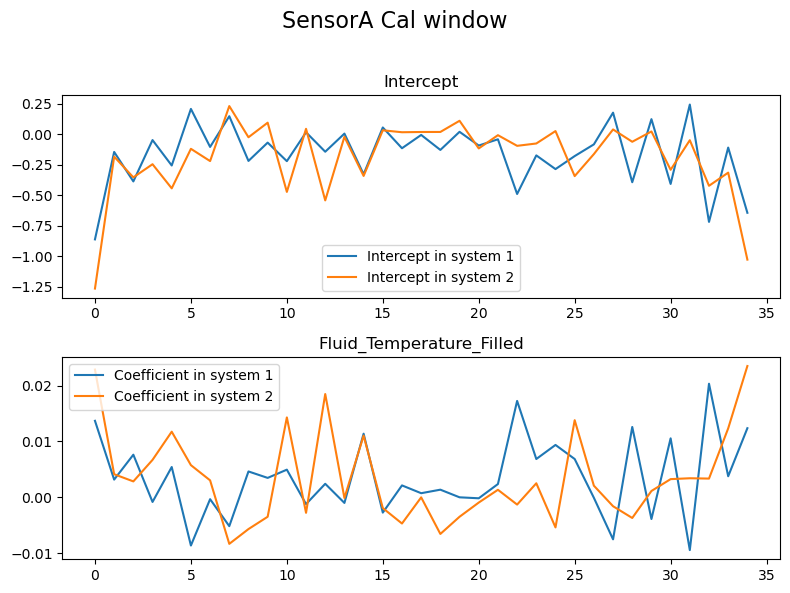

In [29]:
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["Fluid_Temperature_Filled"],range(1,36),"SensorA Cal window")


#### Sample window

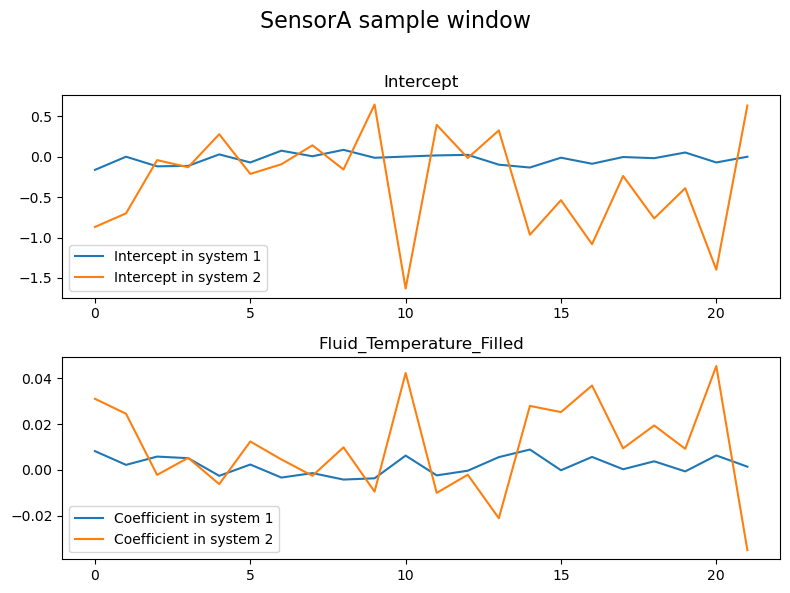

In [30]:
coefficent_visualization(A1_sample_window_funct_reg,A2_sample_window_funct_reg,["Fluid_Temperature_Filled"],range(1,23),"SensorA sample window")

### Sensor B

#### Cal window

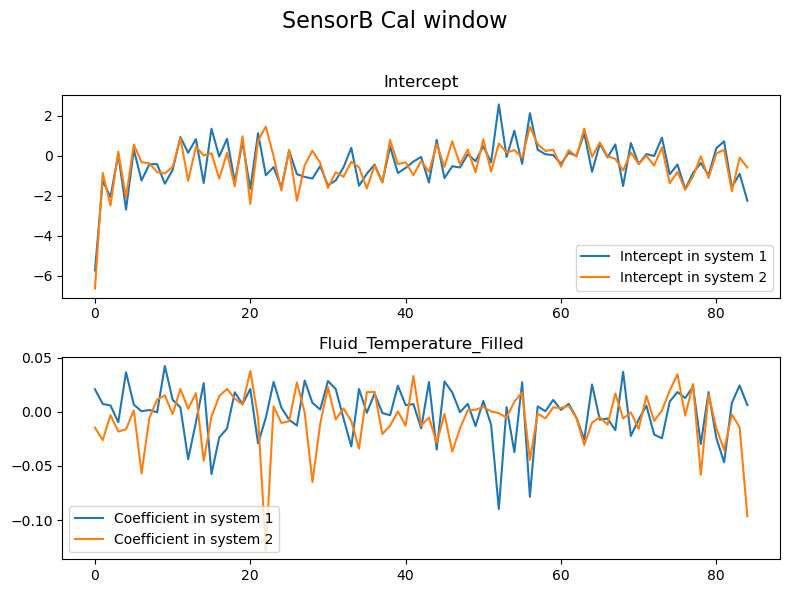

In [31]:
coefficent_visualization(B1_cal_window_funct_reg,B2_cal_window_funct_reg,["Fluid_Temperature_Filled"],range(1,86),"SensorB Cal window")

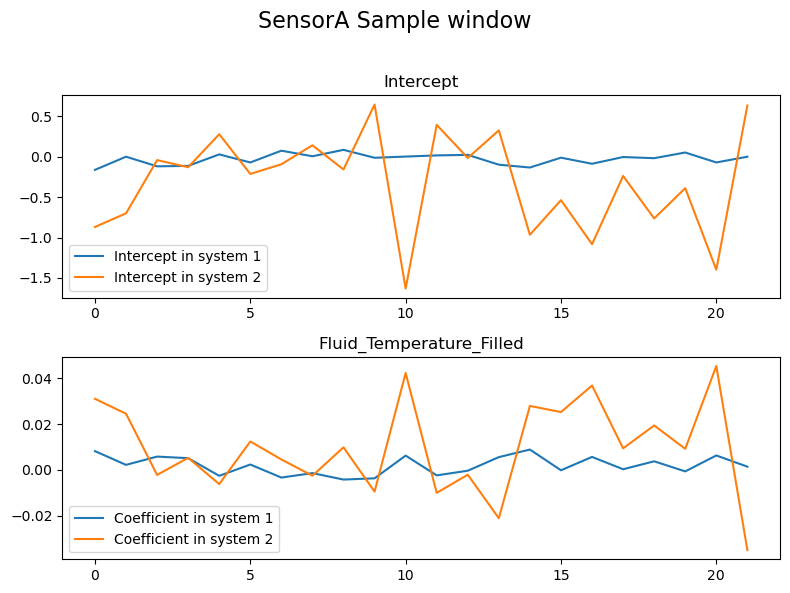

In [32]:
coefficent_visualization(A1_sample_window_funct_reg, A2_sample_window_funct_reg, ["Fluid_Temperature_Filled"], range(1,23), "SensorA Sample window")


#### Sample window

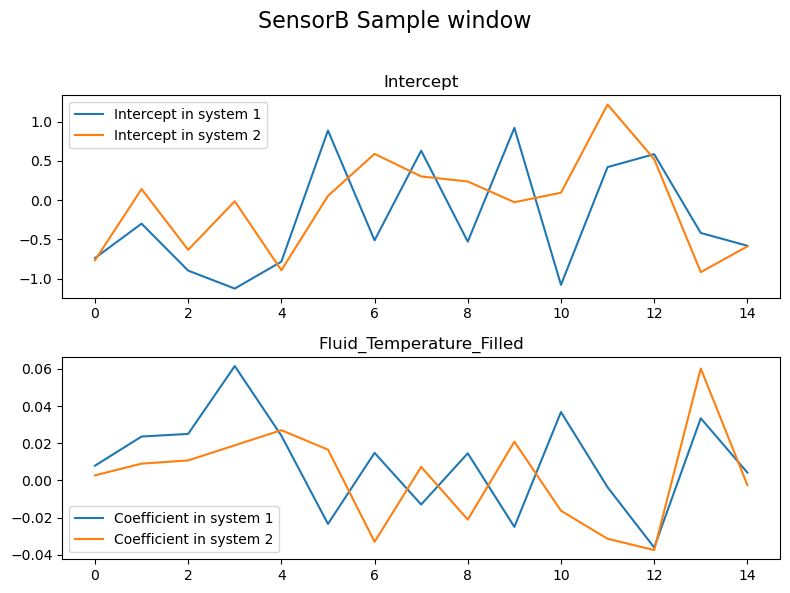

In [33]:
coefficent_visualization(B1_sample_window_funct_reg, B2_sample_window_funct_reg, ["Fluid_Temperature_Filled"], range(1, 16), "SensorB Sample window")